In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

dev = torch.device('cuda:0')
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.FashionMNIST('./data', download=True, 
                                             train=True, transform=transform)
testset = torchvision.datasets.FashionMNIST('./data', download=True, 
                                             train=False, transform=transform)

# pin memory should be 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

classes = ('t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'snesker', 'bag', 'ankle boot')

def matplotlib_imshow(img, one_chanel=False):
    if one_chanel:
#       reduce 0 dimension等于是将三个channel合成一个channel
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    np_img = img.numpy()
    if one_chanel:
        plt.imshow(np_img, cmap='Greys')
    else:
        plt.imshow(np.transpose(np_img, (1, 2, 0.5)))


In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
#       28-(5-1) = 24
        self.pool = nn.MaxPool2d(2, 2)
#       24/2 = 12
        self.conv2 = nn.Conv2d(6, 16, 5)
#         (12 -(5-1)) / 2 = 4 spatial resolution 4*4
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [4]:
from torch.utils.tensorboard import SummaryWriter

# 这里就已经创建了一个folder runs/fashion_mnist_experiment_1
writer = SummaryWriter('runs/fashion_mnist_experiment_1')


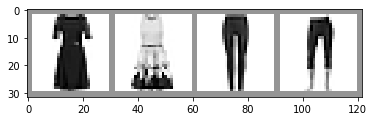

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_chanel=True)

# 使用一个简单的add_image 函数就能添加图片到tensorboard event
writer.add_image('four_fashion_mnist_images', img_grid)

In [6]:
# add graph to visualize the model
writer.add_graph(net, images)
writer.close()

In [7]:
# workaround for error 'module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem''
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

def select_n_random(data, labels, n=100):
    '''
    Select n random data points and their corresponding labels from a dataset
    '''
#     只选取n个data points
    assert len(data) == len(labels)
#     Returns a random permutation of integers from 0 to n - 1
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(trainset.data, trainset.targets)

# get class labels for each image
class_labels = [classes[lab] for lab in labels]

features = images.view(-1, 28*28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.close()

In [8]:
def images_to_probs(net, images):
    output = net(images)
#     如果是单纯的max(Tensor) ，那就只有max_value, 如果有注明dim的话，那就有values和indices
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
#     只是为了获取对应的probability
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_pred(net, images, labels):
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(24, 6))
#     np.arange(4) 会产生一个[0, 1, 2, 3]的array
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_chanel=True)
        ax.set_title('{0}, {1:.1f}%\n(label:{2})'.format(classes[preds[idx]], probs[idx] * 100.0, classes[labels[idx]])
                                                        , color=('green' if preds[idx]==labels[idx.item()] else 'red'))
    return fig

In [9]:
running_loss = 0.0
for epoch in range(1):
    
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:
#             add_image 跟 add_figure 本质上没有区别仅仅一个是plot,一个是图片
            writer.add_scalar('training_loss', running_loss / 1000, epoch * len(trainloader) +i)
            writer.add_figure('predictions vs actuals', plot_classes_pred(net, inputs, labels), global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
    print('finished training')

finished training


In [10]:
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, label = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)
        
        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)
# torch.cat与tf.concat一致，将sequence在指定的dimension merge,不指定时为dim-0
# torch.stack与tf.stack一致Concatenates sequence of tensors along a new dimension,不指定是dim-0
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)
# 反正最后的目标就是对于test_probs shape[10000, 10]
# test_preds shape [10000]

In [15]:
print(len(class_probs))
print(len(class_preds))

2500
2500


In [13]:
print(test_preds.size())
print(test_probs.size())

torch.Size([10000])
torch.Size([10000, 10])


In [17]:
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
#     这样能得到一个[10000]的binary tensor
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]
    
    writer.add_pr_curve(classes[class_index], tensorboard_preds, tensorboard_probs, global_step=global_step)
    writer.close()

for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)